In [1]:
# Logistic Regression Model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import bias_variance_decomp
sns.set()

In [4]:
# reading loand dataset

loans = pd.read_csv('lending_club_loan.csv')

In [5]:
# function for filling in missing mort_acc values

def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [6]:
# feature engineering

loans['loan_repaid'] = loans['loan_status'].map({'Fully Paid':1,'Charged Off':0})
total_acc_avg = loans.groupby('total_acc').mean()['mort_acc']
loans['mort_acc'] = loans.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

#categorical variables
loans['term'] = loans['term'].apply(lambda term: int(term[:3]))
loans['home_ownership']=loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
loans['zip_code'] = loans['address'].apply(lambda address:address[-5:])
loans['earliest_cr_year'] = loans['earliest_cr_line'].apply(lambda date:int(date[:4]))

dummies = pd.get_dummies(loans[['zip_code','home_ownership','grade','verification_status', 'application_type','initial_list_status','purpose' ]],drop_first=True)
loans = loans.drop(['zip_code','address', 'home_ownership', 'grade','verification_status', 'application_type','initial_list_status','purpose'],axis=1)
loans = pd.concat([loans,dummies],axis=1)

loans = loans.drop(['emp_title','emp_length','title','sub_grade', 'issue_d', 'earliest_cr_line', 'loan_status'],axis=1)
loans = loans.dropna() 

In [7]:
# separating attributes from labels

X = loans.drop('loan_repaid',axis=1).values
y = loans['loan_repaid'].values

In [8]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [9]:
# Normalizing the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
#creating baseline model

logreg = LogisticRegression(solver='lbfgs', max_iter = 1000, C = 0.001)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_val)

In [11]:
# classification accuracy on validation data

print(classification_report(y_val, pred))
print('\n Accuracy on validation data: ', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1444
           1       0.81      1.00      0.89      6042

    accuracy                           0.81      7486
   macro avg       0.90      0.50      0.45      7486
weighted avg       0.84      0.81      0.72      7486


 Accuracy on validation data:  0.8075073470478226


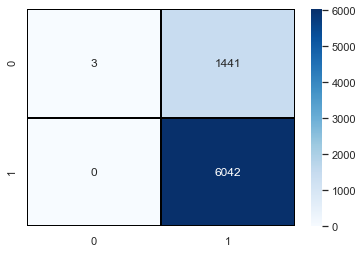

In [12]:
# confusion matrix on validation data

sns.heatmap(confusion_matrix(y_val, pred), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [13]:
# F1 score and  Area under precision-recall curve for validation data

lr_probs = logreg.predict_proba(X_val)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
lr_f1, lr_auc = f1_score(y_val, pred), auc(lr_recall, lr_precision)
print('Logistic Model: F1 score = %.3f PR-AUC = %.3f' % (lr_f1, lr_auc))


Logistic Model: F1 score = 0.893 PR-AUC = 0.956


In [14]:
# finding best parameters for the model with GridSearch method

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val, y_val)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.893401 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [15]:
# Final Model with tuned parameters

logreg_final = LogisticRegression(C=1.0, penalty='l2', solver = 'newton-cg')
logreg_final.fit(X_train, y_train)
prediction = logreg_final.predict(X_test)

In [16]:
# Accuracy of final model on test data

print(classification_report(y_test, prediction))
print('\n Accuracy on test data: ', accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.44      0.61      1395
           1       0.89      1.00      0.94      6092

    accuracy                           0.89      7487
   macro avg       0.93      0.72      0.77      7487
weighted avg       0.90      0.89      0.88      7487


 Accuracy on test data:  0.8935488179511153


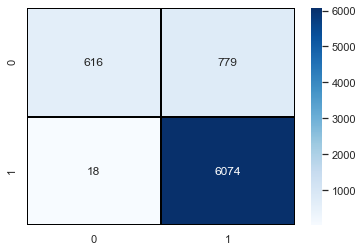

In [17]:
# confusion matrix of test data

sns.heatmap(confusion_matrix(y_test, prediction), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [18]:
# F1 score and PR-AUC on test data

lr_probs = logreg_final.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, prediction), auc(lr_recall, lr_precision)
print('F1 score = %.3f PR-AUC = %.3f' % (lr_f1, lr_auc))


F1 score = 0.938 PR-AUC = 0.977


In [19]:
# Bias and Variance of the model

mse, bias, var = bias_variance_decomp(logreg_final, X_train, y_train, X_test, y_test, loss='mse',
                                      num_rounds=20, random_seed=1)
print('average MSE: %.3f' % mse)
print('average Bias: %.3f' % bias)
print('average Variance: %.3f' % var)

average MSE: 0.107
average Bias: 0.104
average Variance: 0.003
